<a href="https://colab.research.google.com/github/fjadidi2001/Image_Inpaint/blob/main/for1Pic_Jan2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Necessary Libraries

In [1]:
from google.colab import files
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Upload Dataset

Saving Mona_Lisa.jpg to Mona_Lisa.jpg


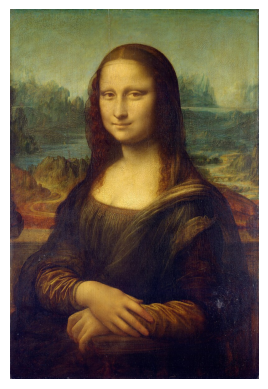

In [2]:
# Upload the file
uploaded = files.upload()

# Open the image using PIL
image = Image.open('Mona_Lisa.jpg')

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

# Create Mask

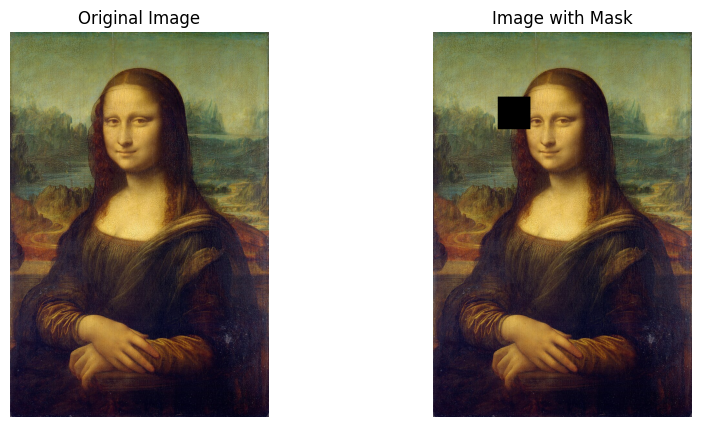

In [3]:
# Create a copy of the image to draw on
masked_image = image.copy()

# Define the square's position and size (left, upper, right, lower)
left = 200
upper = 200
right = 300
lower = 300

# Draw the mask (a filled rectangle) on the image
draw = ImageDraw.Draw(masked_image)
draw.rectangle([left, upper, right, lower], fill=(0, 0, 0, 128))  # Red color with transparency

# Display the original and masked images
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.title('Original Image')

# Masked Image
plt.subplot(1, 2, 2)
plt.imshow(masked_image)
plt.axis('off')  # Hide the axis
plt.title('Image with Mask')

plt.show()

# Create Model for Inpaint

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

class SpatialLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SpatialLSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        # Gates
        self.gates = nn.Linear(input_size + hidden_size, 4 * hidden_size)

        # Initialize weights
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, input_, prev_hidden=None):
        batch_size = input_.size(0)

        if prev_hidden is None:
            zeros = torch.zeros(batch_size, self.hidden_size,
                              dtype=input_.dtype, device=input_.device)
            prev_hidden = (zeros, zeros)

        prev_hidden_state, prev_cell_state = prev_hidden

        # Concatenate input and previous hidden state
        combined = torch.cat((input_, prev_hidden_state), dim=1)

        # Calculate gates
        gates = self.gates(combined)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, dim=1)

        # Apply activations
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        # Update states
        cell_state = (forgetgate * prev_cell_state) + (ingate * cellgate)
        hidden_state = outgate * torch.tanh(cell_state)

        return hidden_state, cell_state

class InpaintingModel(nn.Module):
    def __init__(self, input_channels=3):
        super(InpaintingModel, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(input_channels + 1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # LSTM layers
        self.spatial_lstm = SpatialLSTMCell(256, 256)

        # Decoder
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, input_channels, kernel_size=3, padding=1)

    def forward(self, x, mask):
        # Concatenate input image and mask
        x = torch.cat([x, mask], dim=1)

        # Encoding
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))

        # Reshape for LSTM
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, channels, -1).permute(0, 2, 1)

        # Apply LSTM
        hidden = None
        outputs = []
        for i in range(x.size(1)):
            hidden = self.spatial_lstm(x[:, i, :], hidden)
            outputs.append(hidden[0])

        # Reshape back
        x = torch.stack(outputs, dim=1)
        x = x.permute(0, 2, 1).view(batch_size, channels, height, width)

        # Decoding
        x = F.interpolate(x, scale_factor=2)
        x = F.relu(self.deconv1(x))
        x = F.interpolate(x, scale_factor=2)
        x = F.relu(self.deconv2(x))
        x = torch.tanh(self.deconv3(x))

        return x

# Training function
def train_model(model, train_loader, optimizer, criterion, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, mask) in enumerate(train_loader):
            data, mask = data.to(device), mask.to(device)

            optimizer.zero_grad()
            output = model(data, mask)
            loss = criterion(output, data)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}')

# Preprocessing function
def preprocess_image(image_path, mask_size=(64, 64)):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path)
    image_tensor = transform(image)

    # Create mask
    mask = torch.zeros(1, 256, 256)
    center = 128
    half_size = mask_size[0] // 2
    mask[:, center-half_size:center+half_size, center-half_size:center+half_size] = 1

    return image_tensor.unsqueeze(0), mask.unsqueeze(0)

# Example usage
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model
    model = InpaintingModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Load and preprocess image
    image_tensor, mask = preprocess_image('Mona_Lisa.jpg')
    image_tensor, mask = image_tensor.to(device), mask.to(device)

    # Infer
    model.eval()
    with torch.no_grad():
        output = model(image_tensor, mask)

    # Convert output to image
    output = output.cpu().squeeze(0)
    output = output * 0.5 + 0.5  # Denormalize
    output = transforms.ToPILImage()(output)

    return output

# Added Optimizer

In [10]:
model = InpaintingModel().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
image_tensor, mask = preprocess_image('Mona_Lisa.jpg')

# Train the Model

In [12]:
train_model(model, [(image_tensor, mask)], optimizer, nn.MSELoss(), device='cuda')

Epoch 1/10, Loss: 0.4413
Epoch 2/10, Loss: 0.1654
Epoch 3/10, Loss: 0.2779
Epoch 4/10, Loss: 0.3297
Epoch 5/10, Loss: 0.1288
Epoch 6/10, Loss: 0.0589
Epoch 7/10, Loss: 0.0990
Epoch 8/10, Loss: 0.0587
Epoch 9/10, Loss: 0.0452
Epoch 10/10, Loss: 0.0566


# Image Inpainting Evaluation and Visualization

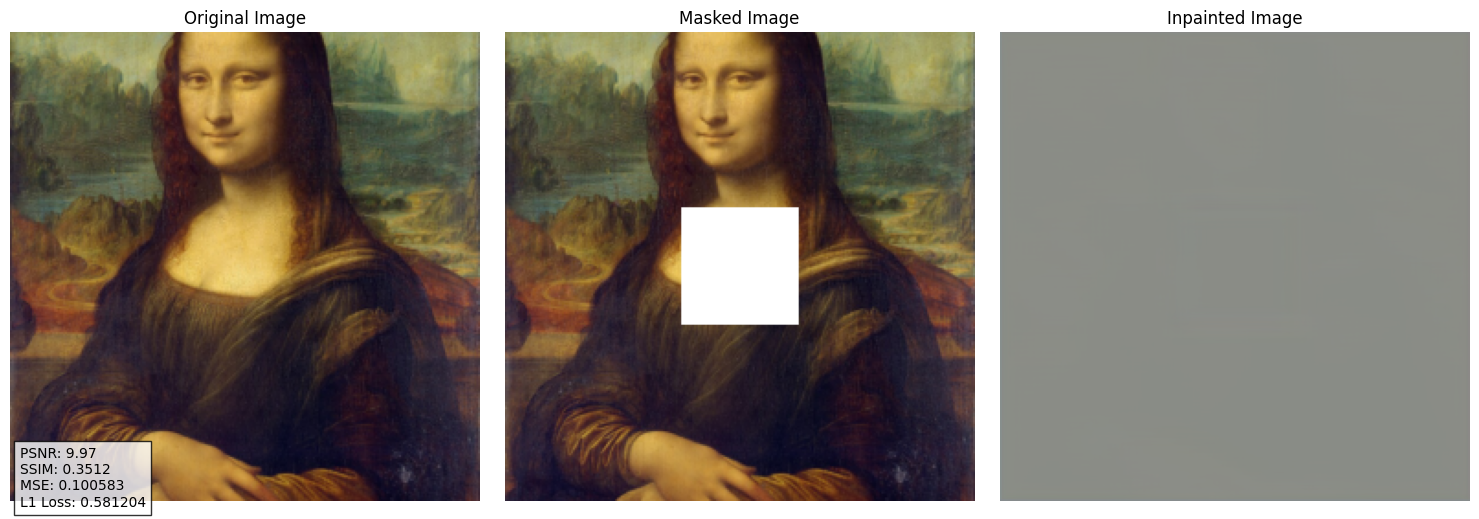


Evaluation Metrics:
PSNR: 9.97 dB
SSIM: 0.3512
MSE: 0.100583
L1 Loss: 0.581204


In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import torchvision.transforms as transforms
from PIL import Image

class InpaintingEvaluator:
    def __init__(self):
        self.metrics = {}

    @staticmethod
    def tensor_to_numpy(tensor):
        """Convert tensor to numpy array and denormalize."""
        img = tensor.cpu().clone()
        img = img.squeeze(0)  # Remove batch dimension
        img = img * 0.5 + 0.5  # Denormalize
        img = img.permute(1, 2, 0).numpy()  # Change to HWC format
        img = np.clip(img, 0, 1)
        return img

    def calculate_mse(self, original, generated):
        """Calculate Mean Squared Error."""
        original = self.tensor_to_numpy(original)
        generated = self.tensor_to_numpy(generated)
        mse = np.mean((original - generated) ** 2)
        return mse

    def calculate_psnr(self, original, generated):
        """Calculate Peak Signal-to-Noise Ratio."""
        original = self.tensor_to_numpy(original)
        generated = self.tensor_to_numpy(generated)
        return psnr(original, generated)

    def calculate_ssim(self, original, generated):
        """Calculate Structural Similarity Index."""
        original = self.tensor_to_numpy(original)
        generated = self.tensor_to_numpy(generated)
        return ssim(original, generated, channel_axis=2, data_range=1.0)

    def calculate_l1_loss(self, original, generated):
        """Calculate L1 (Mean Absolute Error) Loss."""
        criterion = nn.L1Loss()
        return criterion(generated, original).item()

    def evaluate(self, original, masked, generated):
        """Calculate all metrics."""
        self.metrics['mse'] = self.calculate_mse(original, generated)
        self.metrics['psnr'] = self.calculate_psnr(original, generated)
        self.metrics['ssim'] = self.calculate_ssim(original, generated)
        self.metrics['l1_loss'] = self.calculate_l1_loss(original, generated)
        return self.metrics

    def visualize_results(self, original, masked, generated, save_path=None):
        """Visualize original, masked, and generated images side by side."""
        # Convert tensors to numpy arrays
        original_img = self.tensor_to_numpy(original)
        masked_img = self.tensor_to_numpy(masked)
        generated_img = self.tensor_to_numpy(generated)

        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Plot images
        axes[0].imshow(original_img)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(masked_img)
        axes[1].set_title('Masked Image')
        axes[1].axis('off')

        axes[2].imshow(generated_img)
        axes[2].set_title('Inpainted Image')
        axes[2].axis('off')

        # Add metrics as text
        metrics_text = f'PSNR: {self.metrics["psnr"]:.2f}\n'
        metrics_text += f'SSIM: {self.metrics["ssim"]:.4f}\n'
        metrics_text += f'MSE: {self.metrics["mse"]:.6f}\n'
        metrics_text += f'L1 Loss: {self.metrics["l1_loss"]:.6f}'

        plt.figtext(0.02, 0.02, metrics_text, fontsize=10,
                   bbox=dict(facecolor='white', alpha=0.8))

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
        plt.show()

def evaluate_model(model, image_path, mask, device='cuda'):
    """Complete evaluation pipeline."""
    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load original image
    original_image = Image.open(image_path)
    original_tensor = transform(original_image).unsqueeze(0).to(device)

    # Create masked image
    masked_tensor = original_tensor.clone()
    masked_tensor = masked_tensor * (1 - mask) + mask  # Apply mask

    # Generate inpainted image
    model.eval()
    with torch.no_grad():
        generated_tensor = model(masked_tensor, mask)

    # Initialize evaluator
    evaluator = InpaintingEvaluator()

    # Calculate metrics
    metrics = evaluator.evaluate(original_tensor, masked_tensor, generated_tensor)

    # Visualize results
    evaluator.visualize_results(original_tensor, masked_tensor, generated_tensor)

    return metrics

# Example usage
def main():
    # Load your trained model
    model = InpaintingModel().to('cuda')
    # Load your model weights here
    # model.load_state_dict(torch.load('model_weights.pth'))

    # Create mask (example)
    mask = torch.zeros(1, 1, 256, 256)
    center = 128
    mask[:, :, center-32:center+32, center-32:center+32] = 1
    mask = mask.to('cuda')

    # Evaluate
    metrics = evaluate_model(model, 'Mona_Lisa.jpg', mask)

    # Print metrics
    print("\nEvaluation Metrics:")
    print(f"PSNR: {metrics['psnr']:.2f} dB")
    print(f"SSIM: {metrics['ssim']:.4f}")
    print(f"MSE: {metrics['mse']:.6f}")
    print(f"L1 Loss: {metrics['l1_loss']:.6f}")

if __name__ == "__main__":
    main()